#  Dependencies

In [2]:
import os
from pathlib import Path
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import librosa, librosa.display
import pywt
from pydub import AudioSegment
import shutil
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
import wave
import soundfile as sf
import seaborn as sns

# Data loading

In [3]:
train_file= os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/record')
label_file=os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/labels')
event_level=[]
file_name=[]
files=os.listdir(label_file)
records=pd.DataFrame(columns=['Path','record_annotation'])
events=pd.DataFrame(columns=['Path','start','end','type','time'])
for i in files:
    labels=json.load(open(os.path.join(label_file,i)))
    file_name={'Path':Path(i).stem+'.wav'}
    labels.update(file_name) 
    records.loc[len(records.index)]=labels
    event_level=labels['event_annotation']
    if len(event_level)==0:
        file_name.update({'type':'Poor Quality','time':0})
        events.loc[len(events.index)]=file_name
    for x in range(len(event_level)):
        t1=int(event_level[x]['start'])
        t2=int(event_level[x]['end'])
        file_name.update({'time':t2-t1})
        event_level[x].update(file_name)
        events.loc[len(events.index)]=event_level[x]

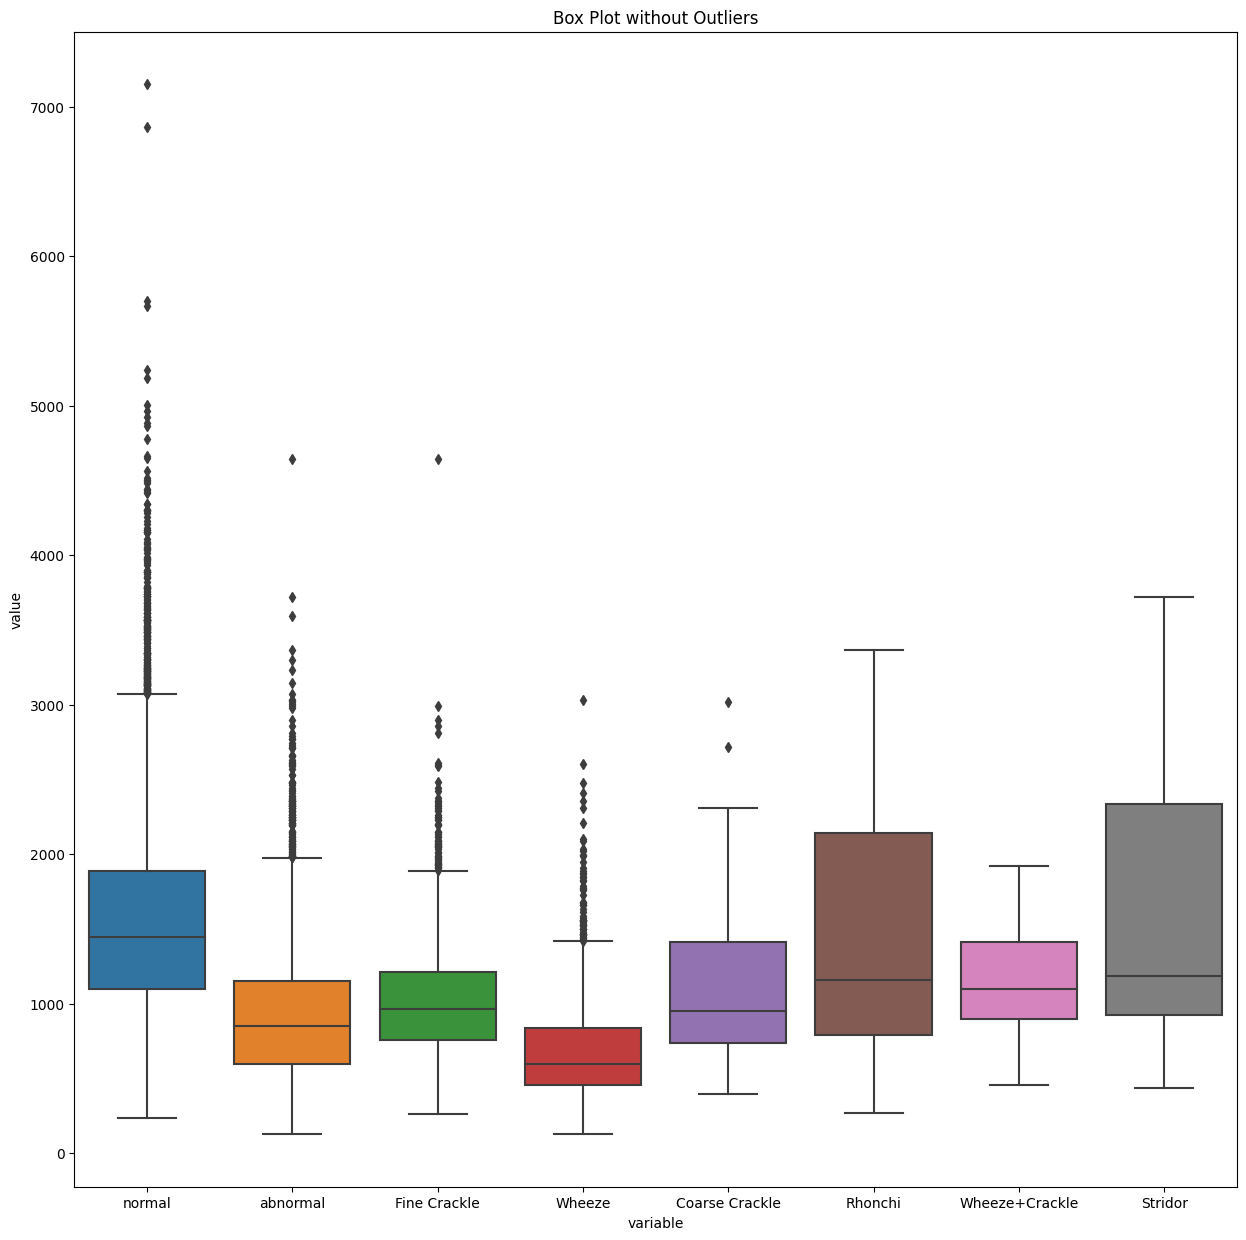

In [4]:
type_0_rows = events[events["type"] == 'Normal']
# Assuming 'events' is your DataFrame
desired_types = ["Fine Crackle", "Wheeze", "Coarse Crackle", "Rhonchi", "Wheeze+Crackle", "Stridor"]

type_1_rows = events[events["type"].isin(desired_types)]
type_1_1=events[events["type"] == "Fine Crackle"]
type_1_2=events[events["type"] == "Wheeze"]
type_1_3=events[events["type"] == "Coarse Crackle"]
type_1_4=events[events["type"] == "Rhonchi"]
type_1_5=events[events["type"] == "Wheeze+Crackle"]
type_1_6=events[events["type"] == "Stridor"]

# Now 'type_1_rows' contains rows where the 'type' column matches any of the desired types

# Filter rows where "type" is 1
m={
    'normal':type_0_rows['time'],
    'abnormal':type_1_rows['time'],
    "Fine Crackle":type_1_1['time'],
    "Wheeze":type_1_2['time'],
    "Coarse Crackle":type_1_3['time'],
    "Rhonchi":type_1_4['time'],
    "Wheeze+Crackle":type_1_5['time'],
    "Stridor":type_1_6['time']
    
}
df = pd.DataFrame(m)
df_melted = pd.melt(df)
plt.figure(figsize=(15,15))
sns.boxplot(x='variable', y='value', data=df_melted, showfliers=True)
plt.title("Box Plot without Outliers")
plt.show()

In [5]:
events["type"].value_counts()

type
Normal            9345
Fine Crackle      1476
Wheeze            1059
Poor Quality       230
Rhonchi            148
Coarse Crackle     100
Stridor             49
Wheeze+Crackle      36
Name: count, dtype: int64

In [6]:
pd.set_option('future.no_silent_downcasting', True)
event_encode={"Normal":0,"Fine Crackle":1,"Wheeze":1,"Coarse Crackle":1,"Rhonchi":1,"Wheeze+Crackle":1,"Stridor":1,"Poor Quality":2}
encoded_event=events.replace({"type":event_encode})
record_encode={"Normal":0,"DAS":1,"CAS":1,"CAS & DAS":1,"Poor Quality":2}
encoded_record=records.replace({"record_annotation":record_encode})
encoded_event.to_csv("salma.csv")

In [7]:
events=encoded_event.copy()


In [8]:
print(type_0_rows.max())
print(type_0_rows.min())

print(type_1_1.max())
print(type_1_1.min())

print(type_1_2.max())
print(type_1_2.min())

print(type_1_3.max())
print(type_1_3.min())

print(type_1_4.max())
print(type_1_4.min())

print(type_1_5.max())
print(type_1_5.min())

print(type_1_6.max())
print(type_1_6.min())

Path     _3.9_1_p4_18147.wav
start                   9999
end                     9994
type                  Normal
time                    7152
dtype: object
Path     00014365_4.3_1_p4_7545.wav
start                             0
end                            1000
type                         Normal
time                            232
dtype: object
Path     66366279_4.9_0_p2_9764.wav
start                          9997
end                            9952
type                   Fine Crackle
time                           4647
dtype: object
Path     40638274_9.7_1_p1_1696.wav
start                         10037
end                           10006
type                   Fine Crackle
time                            258
dtype: object
Path     66366279_4.9_0_p3_9667.wav
start                          9953
end                            9950
type                         Wheeze
time                           3034
dtype: object
Path     40638274_9.7_1_p2_1729.wav
start                        

***droping poor quality***

In [9]:
events.drop(events[events['type']==2].index,inplace=True)
events.reset_index(drop=True, inplace=True)

In [10]:
events=events.sort_values(by='time', ascending=True)
events.reset_index(drop=True)

,Path,start,end,type,time
0,65044711_0.4_1_p4_340.wav,1623,1749,1,126
1,64743918_7.0_0_p2_2835.wav,583,720,1,137
2,64743918_7.0_0_p1_2799.wav,7598,7737,1,139
3,64743918_7.0_0_p1_2799.wav,298,447,1,149
4,40995749_10.5_1_p2_1343.wav,1987,2143,1,156
...,...,...,...,...,...
12208,66318539_10.7_1_p4_5983.wav,4431,9671,0,5240
12209,41227367_6.7_1_p1_625.wav,1604,7269,0,5665
12210,41227367_6.9_1_p2_2659.wav,8395,14097,0,5702
12211,64726870_13.1_1_p3_847.wav,706,7575,0,6869


In [11]:
events[events['type']==1]


,Path,start,end,type,time
11714,65044711_0.4_1_p4_340.wav,1623,1749,1,126
5026,64743918_7.0_0_p2_2835.wav,583,720,1,137
7813,64743918_7.0_0_p1_2799.wav,7598,7737,1,139
7812,64743918_7.0_0_p1_2799.wav,298,447,1,149
4393,40995749_10.5_1_p2_1343.wav,1987,2143,1,156
...,...,...,...,...,...
1283,66236931_2.0_1_p4_5264.wav,912,4214,1,3302
1284,66236931_2.0_1_p4_5264.wav,4346,7712,1,3366
261,66293753_1.3_0_p4_4846.wav,1654,5250,1,3596
262,66293753_1.3_0_p4_4846.wav,5355,9076,1,3721


In [12]:
#removing all records longer than 3.7s 
events.drop(events[events['time']>3721].index,inplace=True)
events.reset_index(drop=True, inplace=True)

In [13]:
# Randomize the DataFrame and reset the index
events = events.sample(frac=1).reset_index(drop=True)

In [14]:
events["type"].value_counts()

type
0    9260
1    2867
Name: count, dtype: int64

In [15]:
#type 0 -type 1=6393
# Define the number of rows to drop
n = 6393 # Replace with your desired number


# Drop n random rows
events = events.drop(events[events['type']==0].sample(n).index)
events.reset_index(drop=True, inplace=True)

type
1    50.0
0    50.0
Name: proportion, dtype: float64

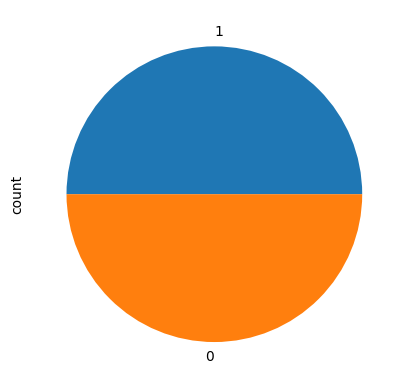

In [16]:
events['type'].value_counts().plot(kind="pie")
events['type'].value_counts(normalize=True)*100


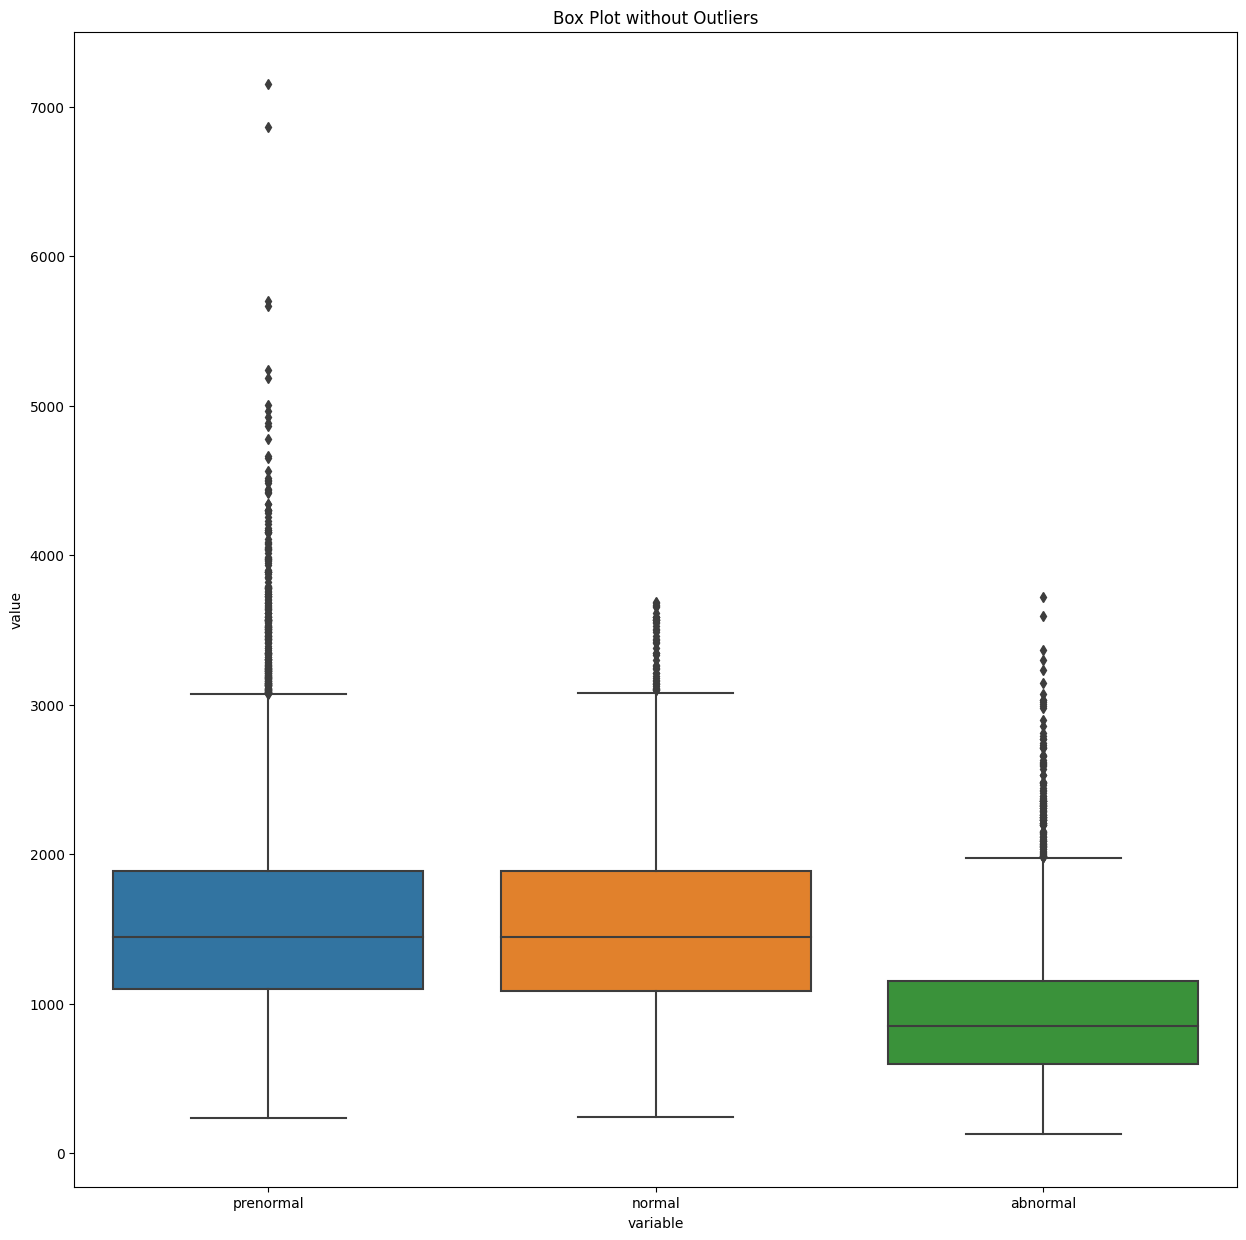

In [17]:
type_0_rows = events[events["type"] == 0]
type_1_rows = events[events["type"]==1]
type_0_1_rows = encoded_event[encoded_event["type"] == 0]
# Assuming 'events' is your DataFrame
# desired_types = ["Fine Crackle", "Wheeze", "Coarse Crackle", "Rhonchi", "Wheeze+Crackle", "Stridor"]
# type_1_rows = events[events["type"].isin(desired_types)]
# type_1_1=events[events["type"] == "Fine Crackle"]
# type_1_2=events[events["type"] == "Wheeze"]
# type_1_3=events[events["type"] == "Coarse Crackle"]
# type_1_4=events[events["type"] == "Rhonchi"]
# type_1_5=events[events["type"] == "Wheeze+Crackle"]
# type_1_6=events[events["type"] == "Stridor"]

# Now 'type_1_rows' contains rows where the 'type' column matches any of the desired types

# Filter rows where "type" is 1
m={
    'prenormal':type_0_1_rows['time'],
    'normal':type_0_rows['time'],
    'abnormal':type_1_rows['time']
#     "Fine Crackle":type_1_1['time'],
#     "Wheeze":type_1_2['time'],
#     "Coarse Crackle":type_1_3['time'],
#     "Rhonchi":type_1_4['time'],
#     "Wheeze+Crackle":type_1_5['time'],
#     "Stridor":type_1_6['time']
    
}
df = pd.DataFrame(m)
df_melted = pd.melt(df)
plt.figure(figsize=(15,15))
sns.boxplot(x='variable', y='value', data=df_melted, showfliers=True)
plt.title("Box Plot without Outliers")
plt.show()

In [18]:
events.to_csv("balanced.csv")

pre_events=events.copy()

In [19]:
train_file= os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/record')
label_file=os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/labels')
#records=pd.read_csv(os.path.join('/kaggle/input/output/records.csv'),index_col=[0])
# events=pd.read_csv(os.path.join('/kaggle/input/output/events.csv'),index_col=[0])
events=pd.read_csv(os.path.join('/kaggle/working/balanced.csv'),index_col=[0])

***making nesscary directories***

In [22]:
# If the directory doesn't exist, create it
if not os.path.exists("fft"):    
    os.mkdir("fft")
if not os.path.exists("stft"):
    os.mkdir("stft")
if not os.path.exists("log_stft"):
    os.mkdir("log_stft")
if not os.path.exists("mel_spec"):
    os.mkdir("mel_spec")
if not os.path.exists("log_mel"):
    os.mkdir("log_mel")
if not os.path.exists("mfcc"):
    os.mkdir("mfcc")
if not os.path.exists("disc_wavelet"):
    os.mkdir("disc_wavelet")
if not os.path.exists("cont_wavelet"):
    os.mkdir("cont_wavelet")
if not os.path.exists("events"):
    os.makedirs("events")
if not os.path.exists("processed"):
    os.makedirs("processed")

***band pass filter***

In [20]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Define your lowcut and highcut frequencies
lowcut = 60.0
highcut = 1300.0

***splitting records to events and applying the band pass filter***

In [23]:
events.drop(events[events['type']==2].index,inplace=True)
events.reset_index(drop=True, inplace=True)
name='name'
events.loc[:, "event_path"] = None

s=0
for i in range(len(events)):
    if name == events['Path'][i]:
        s+=1
    else:
        s=0
        name=events['Path'][i]
    path,t1,t2,_,_,_,= events.loc[i]
    newAudio = AudioSegment.from_wav(os.path.join(train_file,path))
    newAudio = newAudio[int(t1):int(t2)]
    newAudio.export(os.path.join("events",Path(path).stem+"_S"+str(s)+".wav"), format="wav") 
    events.loc[i, "event_path"] = os.path.join('events',Path(path).stem+"_S"+str(s)+".wav")
    # Load the trimmed audio file
    audio, sr = librosa.load(events.loc[i, "event_path"])
    # Apply the filter to the audio
    audio_filtered = butter_bandpass_filter(audio, lowcut, highcut, sr, order=6)
    # Save the filtered audio using soundfile.write instead of librosa.output.write_wav
    sf.write(os.path.join("events",Path(path).stem+"_S"+str(s)+".wav"), audio_filtered, sr)


In [24]:
events

print(events.groupby('type')["time"].max())
print(events.groupby('type')["time"].min())
events.sort_values(by='time', ascending=False)

type
0    3689
1    3721
Name: time, dtype: int64
type
0    239
1    126
Name: time, dtype: int64


,Path,start,end,type,time,event_path
2088,66293753_1.3_0_p4_4846.wav,5355,9076,1,3721,events/66293753_1.3_0_p4_4846_S0.wav
4882,41261802_10.5_0_p1_225.wav,7287,10976,0,3689,events/41261802_10.5_0_p1_225_S0.wav
5034,65091224_2.9_0_p2_3325.wav,7422,11101,0,3679,events/65091224_2.9_0_p2_3325_S0.wav
2382,66252562_11.7_1_p4_4552.wav,2514,6180,0,3666,events/66252562_11.7_1_p4_4552_S0.wav
3769,66345098_13.7_1_p2_7857.wav,748,4408,0,3660,events/66345098_13.7_1_p2_7857_S0.wav
...,...,...,...,...,...,...
1623,40995749_10.5_1_p2_1343.wav,1987,2143,1,156,events/40995749_10.5_1_p2_1343_S0.wav
3701,64743918_7.0_0_p1_2799.wav,298,447,1,149,events/64743918_7.0_0_p1_2799_S0.wav
3764,64743918_7.0_0_p1_2799.wav,7598,7737,1,139,events/64743918_7.0_0_p1_2799_S0.wav
3704,64743918_7.0_0_p2_2835.wav,583,720,1,137,events/64743918_7.0_0_p2_2835_S0.wav


***making the audio of equal length***

In [25]:
aver = events['time'].mean()/1000
print(aver)

1.2320008719916289


In [ ]:
aver = events['time'].mean()/1000
# Specify frame parameters
events.loc[:,"Address"]=None
for i in range(0,len(events)):
    # Load an example audio file (replace with your own data)
    filename=os.path.join(events['event_path'][i])
    _,_,_,_,event_path,_,_ = events.loc[i]
    y, sr = librosa.load(filename)
    # Frame the audio signal
    # Specify the path to your WAV file
    # Open the WAV file
    with wave.open(filename, 'r') as mywav:
        frames = mywav.getnframes()
       # print (frames)
        framerate = mywav.getframerate()
        duration_seconds = frames / float(framerate)
        _, sound = os.path.split('/kaggle/input/output')
    #print(f"Length of the WAV file: **{duration_seconds:.1f} seconds**")
    if (duration_seconds>aver):
        start=(duration_seconds-aver/2)*1000
        end=(duration_seconds+aver/2)*1000
        # Load the audio file
        audio = AudioSegment.from_wav(filename)
        # Trim the audio (e.g., from 0 to 250 milliseconds)
        trimmed_audio = audio[:end]
        final_audio=trimmed_audio[start:]
        final_audio.export(os.path.join("processed",Path(sound).stem+"t"+".wav"), format="wav")
        events.loc[i, "Address"] = os.path.join('processed',Path(sound).stem+"t"+".wav")
    elif(duration_seconds<=aver):
        from pydub import AudioSegment
        silence_before = AudioSegment.silent(duration=250)
        silence_after = AudioSegment.silent(duration=250)

# Combine audio segments
        padded_audio = silence_before + audio + silence_after
# Calculate total duration (including padding)
        total_duration = len(audio) + 2 * 250  # Add silence before and after
        pad=(aver-duration_seconds)/2
          # Pad the audio (e.g., add 750 milliseconds of silence)
        padded_audio = AudioSegment.silent(duration=250) + audio + AudioSegment.silent(duration=250)
        # Export the padded audio
        events.loc[i, "Address"] = os.path.join('processed',Path(sound).stem+"p"+".wav")
        padded_audio.export(os.path.join("processed", Path(sound).stem + "p" + ".wav"), format="wav")
        
        


   

In [27]:
average = events['time'].mean()
print(average)

1232.0008719916289


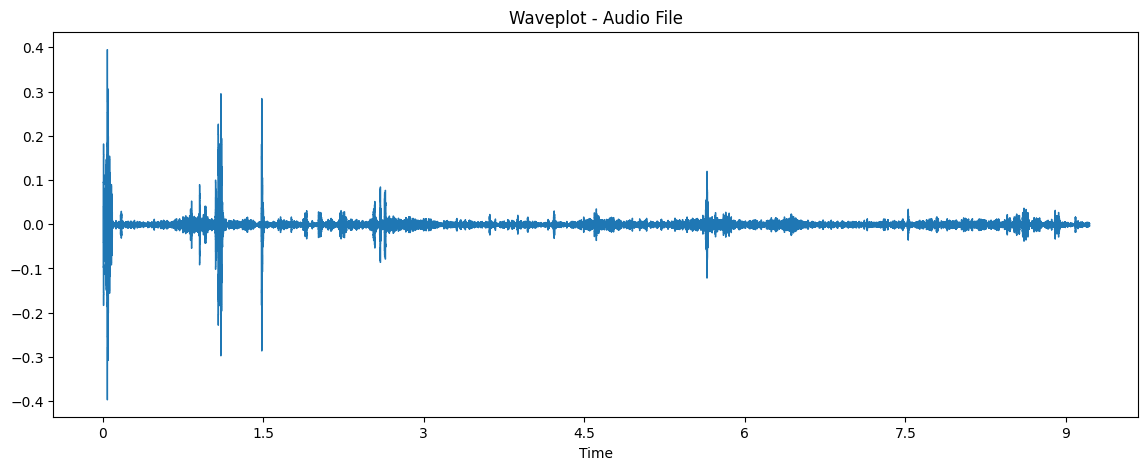

In [28]:
y, sr = librosa.load('/kaggle/input/sprsound-nosplit/SPRSound-main/record/66327579_5.9_1_p3_6380.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

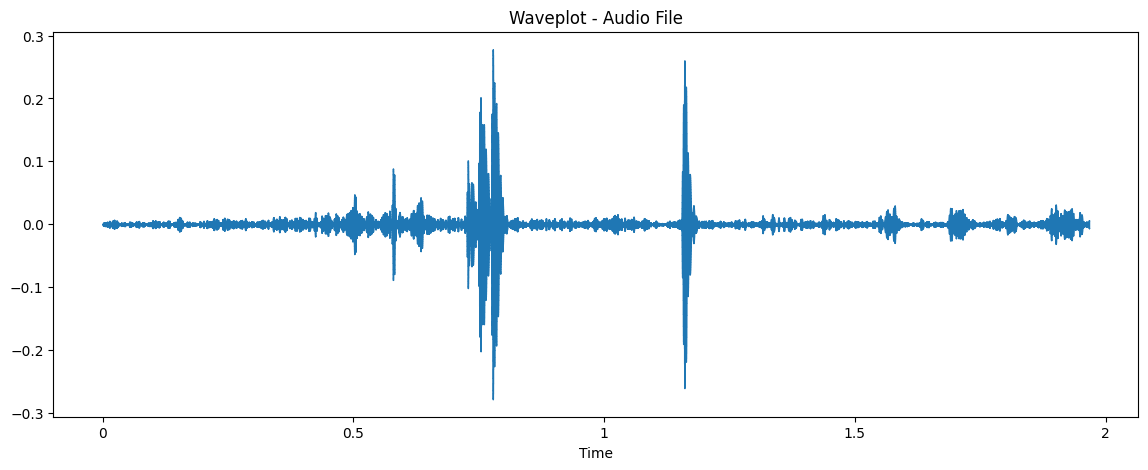

In [219]:
y, sr = librosa.load('/kaggle/working/events/66327579_5.9_1_p3_6380_S0.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

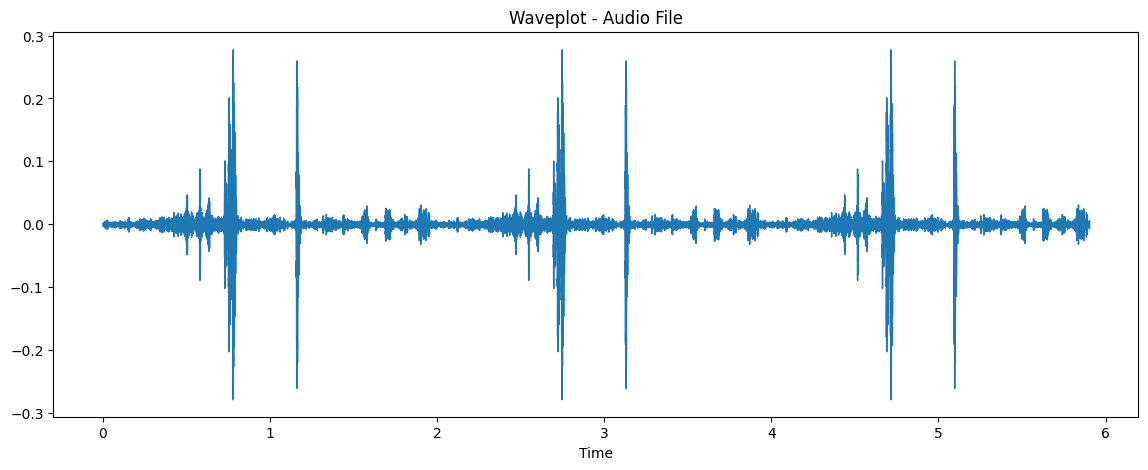

In [29]:
y, sr = librosa.load('/kaggle/working/events/66327579_5.9_1_p3_6380_S0.wav')
y=np.tile(y,3)
# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

In [ ]:
y, sr = librosa.load('/kaggle/working/events/66327579_5.9_1_p3_6380_S2.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

In [ ]:
events.to_csv("events_processed.csv")

# parameter

In [34]:
FIG_SIZE = (2.24,2.24)
sr=8000
hop_length = 25 # in num. of samples
n_fft = 2048 # window in num. of samples

repeat=6
# a=np.array([1,2,3,23])
# b=np.tile(a,repeat)

# plotting

In [ ]:
events

In [28]:
len(events)

5734

In [ ]:
for i in range(int(len(events)//20)):
#     file=events["event_path"][i]
    _, sound = os.path.split(events["event_path"][i])
    signal, sample_rate = librosa.load(os.path.join("/kaggle/working",events["event_path"][i]), sr=sr)
    signal = np.tile(signal, repeat)
#     # FFT -> power spectrum
#     fft = np.fft.fft(signal)
#     spectrum = np.abs(fft)
#     # create frequency variable
#     f = np.linspace(0, sample_rate, len(spectrum))
#     left_spectrum = spectrum[:int(len(spectrum)/2)]
#     left_f = f[:int(len(spectrum)/2)]
#     # plot spectrum
#     plt.figure(figsize=FIG_SIZE)
#     plt.plot(left_f, left_spectrum, alpha=0.4)
#     plt.axis('off')
#     plt.savefig(os.path.join('fft',Path(sound).stem+'.png'), dpi=100, bbox_inches='tight',pad_inches=0)
#     events.loc[i, "fft_path"] = os.path.join('fft',Path(sound).stem+'.png')
#     plt.close()

    # STFT -> spectrogram
    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate
    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))
    # perform stft
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)
    # display spectrogram
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.axis('off')
    plt.savefig(os.path.join('stft',Path(sound).stem+'.png'), dpi=100, bbox_inches='tight',pad_inches=0)
    events.loc[i, "stft_path"] = os.path.join('stft',Path(sound).stem+'.png')
    plt.close()
  
  # apply logarithm to cast amplitude to Decibels
#     log_spectrogram = librosa.amplitude_to_db(spectrogram)
#     plt.figure(figsize=FIG_SIZE)
#     librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
#    # librosa.display.cmap(data, *, robust=True, cmap_seq='magma', cmap_bool='gray_r', cmap_div='coolwarm')
#     plt.axis('off')
#     plt.savefig(os.path.join('log_stft',Path(sound).stem+'.png'), dpi=300, bbox_inches='tight',pad_inches=0)
#     events.loc[i, "log_stft_path"] = os.path.join('log_stft',Path(sound).stem+'.png')
# #     plt.close()
    
#     # MFCCs
#     # extract 13 MFCCs
#     MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
#     # display MFCCs
#     plt.figure(figsize=FIG_SIZE)
#     librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
#     plt.axis('off')
#     plt.savefig(os.path.join('mfcc',Path(events["Address"][i]).stem+'.png'), dpi=300, bbox_inches='tight',pad_inches=0)
#     events.loc[i, "mfcc_path"] = os.path.join('mfcc',Path(events["Address"][i]).stem+'.png')
# #     plt.close()
    
#     # Mel Spectrogram
#     melspectrum = librosa.feature.melspectrogram(y=signal, sr=sample_rate, hop_length=hop_length, window='hann', n_mels=256)
#     # display Mel spectrogram
#     plt.figure(figsize=FIG_SIZE)
#     librosa.display.specshow(melspectrum, sr=sample_rate, hop_length=hop_length)
#     plt.axis('off')
#     plt.savefig(os.path.join('mel_spec',Path(events["Address"][i]).stem+'.png'), dpi=300, bbox_inches='tight',pad_inches=0)
#     events.loc[i, "mel_spec_path"] = os.path.join('mel_spec',Path(events["Address"][i]).stem+'.png')
# #     plt.close()
    
#      # Log Mel Spectrogram
#     ps = librosa.feature.melspectrogram(y=signal, sr=sample_rate)
#     ps_db = librosa.power_to_db(ps, ref=np.max)
#     plt.figure(figsize=FIG_SIZE)
#     librosa.display.specshow(ps_db, sr=sample_rate, hop_length=hop_length)
#     plt.axis('off')
#     plt.savefig(os.path.join('log_mel',Path(events["Address"][i]).stem+'.png'), dpi=300, bbox_inches='tight',pad_inches=0)
#     events.loc[i, "log_mel_path"] = os.path.join('log_mel',Path(events["Address"][i]).stem+'.png')
# #     plt.close()
    
#     # Wavelet Transform
#     cA, cD = pywt.dwt(signal, 'db1')
#     # Plot Wavelet Transform
#     plt.figure(figsize=FIG_SIZE)
#     plt.plot(cA)  # Plot approximation coefficients
#     plt.plot(cD)  # Plot detail coefficients
#     plt.axis('off')
#     # Save the figure
#     plt.savefig(os.path.join('disc_wavelet', Path(events["Address"][i]).stem + '.png'), dpi=300, bbox_inches='tight', pad_inches=0)
#     # Update the DataFrame
#     events.loc[i, "disc_wavelet_path"] = os.path.join('disc_wavelet', Path(events["Address"][i]).stem + '.png')
# #     plt.close()

#  # Compute the Continuous Wavelet Transform (CWT)
#     scales = np.arange(1, 500)


#     [cwt, frequencies] = pywt.cwt(signal, scales, 'morl')
#     # Create a time vector
#     time = np.arange(0, len(signal)) / 2000
#     # Plot the wavelet spectrogram
#     plt.figure(figsize=FIG_SIZE)
#     plt.imshow(abs(cwt), aspect='auto', cmap='jet', extent=[time.min(), time.max(), frequencies.min(), frequencies.max()])
#     plt.axis('off')
#     # Save the figure
#     plt.savefig(os.path.join('cont_wavelet', Path(events["Address"][i]).stem + '.png'), dpi=300, bbox_inches='tight', pad_inches=0)
#     # Update the DataFrame
#     events.loc[i, "cont_wavelet_path"] = os.path.join('cont_wavelet', Path(events["Address"][i]).stem + '.png')
# #     plt.close()




In [ ]:
if  os.path.exists("fft"):    
    shutil.rmtree("fft")
if  os.path.exists("stft"):
    shutil.rmtree("stft")
if  os.path.exists("log_stft"):
    shutil.rmtree("log_stft")
if  os.path.exists("mel_spec"):
    shutil.rmtree("mel_spec")
if  os.path.exists("log_mel"):
    shutil.rmtree("log_mel")
if  os.path.exists("mfcc"):
    shutil.rmtree("mfcc")
if  os.path.exists("disc_wavelet"):
    shutil.rmtree("disc_wavelet")
if  os.path.exists("cont_wavelet"):
    shutil.rmtree("cont_wavelet")